# Read in Data

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, fbeta_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer, LancasterStemmer

import gensim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv("../input/train_v2.csv")
test_data = pd.read_csv("../input/test_v2.csv")

In [3]:
train_data.head(1)

,article_id,title,url,publisher,hostname,timestamp,category
0,1,Forex - Pound drops to one-month lows against ...,http://www.nasdaq.com/article/forex-pound-drop...,NASDAQ,www.nasdaq.com,1.390000e+12,4


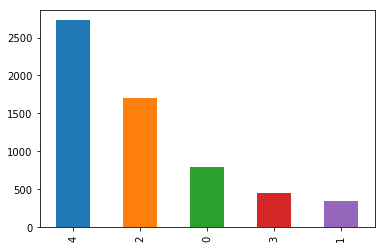

In [11]:
train_data.category.value_counts().plot('bar')

# Housekeeping

In [12]:
def stem(sent, stemmer_type='porter'):
    '''
    stemmer_type can be porter, lancaster, or snowball
    '''
    if stemmer_type == 'porter':
        stemmer = PorterStemmer()
    elif stemmer_type == 'lancaster':
        stemmer = LancasterStemmer()
    else:
        stemmer = SnowballStemmer('english')
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([stemmer.stem(word) for word in words])

In [13]:
def lemmatize(sent):
    lemmatizer = WordNetLemmatizer()
    
    words = gensim.utils.simple_preprocess(sent)
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

In [14]:
train_data["title"][1]

'Hertz to Exit Equipment Rental Business in $2.5B Spinoff'

In [15]:
train_data["title"].apply(stem)[1]

'hertz to exit equip rental busi in spinoff'

In [16]:
# perform stemming
train_data.loc[:, "title"] = train_data["title"].apply(stem)
test_data.loc[:, "title"] = test_data["title"].apply(stem)

In [17]:
# X_train, X_test, Y_train, Y_test = train_test_split(train_data["title"], train_data["category"], test_size = 0.2)
# X_train = np.array(X_train)
# X_test = np.array(X_test)  # indeed X_valid is a more accurate name
# Y_train = np.array(Y_train)
# Y_test = np.array(Y_test)  # indeed Y_valid is a more accurate name

In [18]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_valid, label_valid):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return {'accuracy': accuracy_score(label_valid, predictions), 
            # 'f2_seperate': fbeta_score(Y_test, Y_predict, average=None, beta=2),
            'f2_macro': fbeta_score(label_valid, predictions, average='macro', beta=2),
            'f2_micro': fbeta_score(label_valid, predictions, average='micro', beta=2),
            'f2_weighted': fbeta_score(label_valid, predictions, average='weighted', beta=2)}

In [19]:
def cross_validation_data(train_data):
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
    
    for train_index, test_index in sss.split(train_data["title"], train_data["category"]):
        X_train, X_test = train_data["title"][train_index], train_data["title"][test_index]
        Y_train, Y_test = train_data["category"][train_index], train_data["category"][test_index]
        yield X_train, Y_train, X_test, Y_test

In [13]:
# # Not performing well
# def random_sample(X, y, method='RandomOverSampler'):
#     if method == 'RandomOverSampler':
#         sampler = RandomOverSampler()
#     elif method == 'RandomUnderSampler':
#         sampler = RandomUnderSampler()
#     elif method == 'ADASYN':
#         sampler = ADASYN()
#     elif method == 'SMOTE':
#         sampler = SMOTE()

#     return sampler.fit_sample(X, y)

In [14]:
# le_hostname = preprocessing.LabelEncoder()
# le_hostname.fit_transform(train_data['hostname']).shape

# le_publisher = preprocessing.LabelEncoder()
# le_publisher.fit_transform(train_data['publisher'].fillna('UNKNOWN'))

# Count Vectorizer

In [30]:
count_vect = CountVectorizer(analyzer='word',
                             ngram_range=(1,2),
                             # token_pattern=r'\w{1,}',
                             min_df=1,
                             max_features=4000)
count_vect.fit(train_data["title"].tolist() + test_data["title"].tolist())
# count_vect.fit(train_data["title"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
for clf_name, clf in [('LR', LogisticRegression()),
                      ('NB', MultinomialNB()),
                      ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
                      ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))]:
    metrics_list = []
    for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
        xtrain_count =  count_vect.transform(X_train)
        xvalid_count =  count_vect.transform(X_test)
        if clf_name == 'XGB':
            metrics = train_model(clf, xtrain_count.tocsc(), Y_train, xvalid_count.tocsc(), Y_test)
        else:
            metrics = train_model(clf, xtrain_count, Y_train, xvalid_count, Y_test)
        metrics_list.append(metrics)
    print(clf_name, "mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
    print(clf_name, "mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
    print()

/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ruizhi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR mean accuracy: 0.6427031509121062
LR mean f2_macro: 0.5571113588106928
LR mean f2_micro: 0.6427031509121062
LR mean f2_weighted: 0.6374668341887142

NB mean accuracy: 0.6372305140961857
NB mean f2_macro: 0.5792688637243283
NB mean f2_micro: 0.6372305140961857
NB mean f2_weighted: 0.635536090627901



KeyboardInterrupt: 

In [77]:
# clf = RandomForestClassifier(n_estimators=180, criterion='entropy')
# accuracy = train_model(clf, xtrain_count, Y_train, xvalid_count, Y_test)

# Y_predict = clf.predict(xvalid_count)
# print(fbeta_score(Y_test, Y_predict, average=None, beta=1))
# print(fbeta_score(Y_test, Y_predict, average='macro', beta=1))
# print(fbeta_score(Y_test, Y_predict, average='weighted', beta=1))

# TF-IDF

In [42]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,2), 
                                   max_df=1.0,
                                   min_df=1,
                                   max_features=4000)
tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())
# tfidf_vect_ngram.fit(train_data["title"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [136]:
for clf_name, clf in [('LR', LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')),
                      ('NB', MultinomialNB()),
                      ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
                      ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))]:
    metrics_list = []
    for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
        xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
        xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
        if clf_name == 'XGB':
            metrics = train_model(clf, xtrain_tfidf_ngram.tocsc(), Y_train, xvalid_tfidf_ngram.tocsc(), Y_test)
        else:
            metrics = train_model(clf, xtrain_tfidf_ngram, Y_train, xvalid_tfidf_ngram, Y_test)
        metrics_list.append(metrics)
    print(clf_name, "mean accuracy:", sum([item['accuracy'] for item in metrics_list])/len(metrics_list))
    print(clf_name, "mean f2_macro:", sum([item['f2_macro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_micro:", sum([item['f2_micro'] for item in metrics_list])/len(metrics_list))    
    print(clf_name, "mean f2_weighted:", sum([item['f2_weighted'] for item in metrics_list])/len(metrics_list))  
    print()

LR mean accuracy: 0.6563847429519072
LR mean f2_macro: 0.5478208767241433
LR mean f2_micro: 0.6563847429519072
LR mean f2_weighted: 0.6471283940542423

NB mean accuracy: 0.6540630182421228
NB mean f2_macro: 0.5217897243700211
NB mean f2_micro: 0.6540630182421228
NB mean f2_weighted: 0.641110679139451



KeyboardInterrupt: 

In [ ]:
# xtrain_tfidf_resampled, Y_train_resampled = random_sample(xtrain_tfidf_ngram, Y_train, method='ADASYN')

# # Extereme Gradient Boosting on Word Level TF IDF Vectors
# accuracy = train_model(xgboost.XGBClassifier(max_depth=5, n_estimators=140), xtrain_tfidf_resampled.tocsc(), Y_train_resampled, xvalid_tfidf_ngram.tocsc(), Y_test)
# print("Xgb, WordLevel TF-IDF: ", accuracy)

In [ ]:
# clf = xgboost.XGBClassifier(max_depth=5, n_estimators=140)
# accuracy = train_model(clf, xtrain_tfidf_resampled.tocsc(), Y_train_resampled, xvalid_tfidf_ngram.tocsc(), Y_test)

# Y_predict = clf.predict(xvalid_tfidf_ngram.tocsc())
# print(fbeta_score(Y_test, Y_predict, average=None, beta=1))

# Try Voting

In [117]:
def fuse_results(predictions_list, xgb_offset=1):
    final_predictions = []
    percentage = 0
    for preds in zip(*predictions_list):
        sr_count = pd.Series(preds).value_counts()
        if sr_count.iloc[0] >= 2 and sr_count.index[0] != preds[1]:
            final_predictions.append(sr_count.index[0])  # the most commonly predicted class
            percentage +=1
        else:
            final_predictions.append(preds[1])  # use result of xgb
    
    print(percentage)
    return final_predictions

In [142]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',
                                   # token_pattern=r'\w{1,}', 
                                   ngram_range=(1,2), 
                                   max_df=1.0,
                                   min_df=2,
                                   max_features=4000)
tfidf_vect_ngram.fit(train_data["title"].tolist() + test_data["title"].tolist())
# tfidf_vect_ngram.fit(train_data["title"])


acc_list = []
for X_train, Y_train, X_test, Y_test in cross_validation_data(train_data):
    xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
    xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)
    
    predictions_list = []
    for clf_name, clf in [
                          ('KNN', KNeighborsClassifier(n_neighbors=40, weights='distance')),
#                           ('LR', LogisticRegression()),
#                           ('LR', LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')),
                          ('NB', MultinomialNB(alpha=0.5, fit_prior=True)),
#                           ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy')),
                          ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
#                           ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))
                         ]:
        if clf_name == 'XGB':
            clf.fit(xtrain_tfidf_ngram.tocsc(), Y_train)
            predictions = clf.predict(xvalid_tfidf_ngram.tocsc())
        else:
            clf.fit(xtrain_tfidf_ngram, Y_train)
            predictions = clf.predict(xvalid_tfidf_ngram)
    
        predictions_list.append(predictions)
    
    final_predictions = fuse_results(predictions_list)
    accuracy = accuracy_score(Y_test, final_predictions)
    print(accuracy)
    acc_list.append(accuracy)

print(sum(acc_list)/len(acc_list))

41
0.6575456053067993
43
0.6558872305140961
56
0.6716417910447762
56
0.6658374792703151
58
0.6749585406301825
50
0.664179104477612
59
0.6650082918739635
51
0.6890547263681592
56
0.693200663349917
72
0.6509121061359867
0.6688225538971808


In [ ]:
# lr, rf, xgb
# 0.6624378109452737

# lr_ovr, nb, xgb
# 0.6604477611940299

# knn, lr, xgb
# 0.6640132669983416

# knn, nb, xgb
# 0.6688225538971808

# knn, rf, xgb
# 0.6671641791044776

# nb, rf, xgb
# 0.6629353233830845

In [145]:
# create submission
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data["title"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_data["title"])

    
predictions_list = []
for clf_name, clf in [
                      ('KNN', KNeighborsClassifier(n_neighbors=40, weights='distance')),
#                       ('LR', LogisticRegression()),
#                       ('LR', LogisticRegression(penalty='l2', C=2, solver='liblinear', multi_class='ovr')),
                      ('NB', MultinomialNB(alpha=0.5, fit_prior=True)),
#                       ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy')),
                      ('XGB', xgboost.XGBClassifier(max_depth=5, n_estimators=140)),
#                       ('RF', RandomForestClassifier(n_estimators=180, criterion='entropy'))
                     ]:
    if clf_name == 'XGB':
        clf.fit(train_tfidf_ngram.tocsc(), train_data["category"])
        predictions = clf.predict(test_tfidf_ngram.tocsc())
    else:
        clf.fit(train_tfidf_ngram, train_data["category"])
        predictions = clf.predict(test_tfidf_ngram)

    predictions_list.append(predictions)

final_predictions = fuse_results(predictions_list)

test_data["category"] = final_predictions

out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)

137


# Create Submission

In [77]:
train_tfidf_ngram =  tfidf_vect_ngram.transform(train_data["title"])
test_tfidf_ngram =  tfidf_vect_ngram.transform(test_data["title"])

In [26]:
classifier = xgboost.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=140)
metrics = train_model(classifier, train_tfidf_ngram.tocsc(), train_data["category"], train_tfidf_ngram.tocsc(), train_data["category"])
print("XGB on training set ", metrics)

test_data["category"] = classifier.predict(test_tfidf_ngram.tocsc())

XGB on training set  0.7375145180023229


In [78]:
classifier = KNeighborsClassifier(n_neighbors=40, weights='distance')
metrics = train_model(classifier, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])
print("XGB on training set ", metrics)

test_data["category"] = classifier.predict(test_tfidf_ngram)

XGB on training set  {'accuracy': 0.9905425584868094, 'f2_macro': 0.9906536277966065, 'f2_micro': 0.9905425584868094, 'f2_weighted': 0.9905380591051429}


In [27]:
# classifier = RandomForestClassifier(n_estimators=180, criterion='entropy')
# metrics = train_model(classifier, train_tfidf_ngram, train_data["category"], train_tfidf_ngram, train_data["category"])
# print("RF on training set ", metrics)

# test_data["category"] = classifier.predict(test_tfidf_ngram)

In [79]:
out=pd.DataFrame(test_data,columns=['article_id','category'])
out.to_csv('prediction.csv',index=False)